In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def rho_green_light(x, rho_light):
    rho = numpy.zeros_like(x)
    mask = numpy.where(x < 2.0)
    rho[mask] = rho_light * x[mask] / 2.0
    return rho

In [4]:
nx = 81
L = 4.0
dx = L / (nx - 1)
nt = 30
u_max = 1.0
rho_max = 10.0
rho_light = 10.0

x = numpy.linspace(0.0, L, num=nx)

rho0 = rho_green_light(x, rho_light)

In [5]:
def flux(rho, u_max, rho_max):
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [6]:
def godunov(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        rhoL = rho[:-1]
        rhoR = rho[1:]
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) -
                   dx / dt * (rhoR - rhoL))
        rho[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        rho[0], rho[-1] = bc_values
        rho_hist.append(rho.copy())
    return rho_hist

In [7]:
sigma = 1.0
dt = sigma * dx / u_max

rho_hist = godunov(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                   u_max, rho_max)

In [8]:
from matplotlib import animation
from IPython.display import HTML

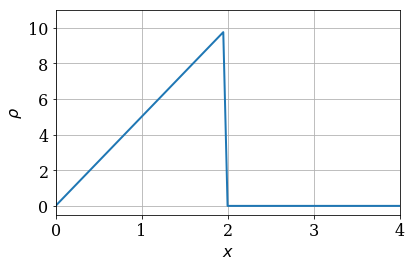

In [9]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                    color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0)
fig.tight_layout()

In [10]:
def update_plot(n, rho_hist):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [11]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
HTML(anim.to_html5_video())

In [12]:
def minmod(e, dx):
    """
    Computes the minmod approximation of the slope.
    
    Parameters
    ----------
    e : list or numpy.ndarray
        The input values as a 1D array of floats.
    dx : float
        The grid-cell width.
    
    Returns
    -------
    sigma : numpy.ndarray
        The minmod-approximated slope
        as a 1D array of floats.
    """
    sigma = numpy.zeros_like(e)
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i - 1]) / dx
        de_plus = (e[i + 1] - e[i]) / dx
        if de_minus > 0 and de_plus > 0:
            sigma[i] = min(de_minus, de_plus)
        elif de_minus < 0 and de_plus < 0:
            sigma[i] = max(de_minus, de_plus)
        else:
            sigma[i] = 0.0
    return sigma

In [13]:
def muscl(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes and returns the history of the traffic density
    on the road using a MUSCL scheme with a minmod slope limiting
    and a Lax-Friedrichs flux.
    The function uses a second-order Runge-Kutta method
    to integrate in time.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : tuple or list
        The value of the density at the first and last locations
        as a tuple or list of two floats.
    args : list
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
        as a list of 1D array of floats.
    """
    def compute_flux(rho):
        # Compute the minmod slope.
        sigma = minmod(rho, dx)
        # Reconstruct values at cell boundaries.
        rhoL = (rho + sigma * dx / 2.0)[:-1]
        rhoR = (rho - sigma * dx / 2.0)[1:]
        # Compute the flux.
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) -
                   dx / dt * (rhoR - rhoL))
        return F
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        # Compute the flux at cell boundaries.
        F = compute_flux(rho)
        # Perform 1st step of RK2.
        rho_star[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        # Apply boundary conditions.
        rho_star[0], rho_star[-1] = bc_values
        # Compute the flux at cell boundaries.
        F = compute_flux(rho_star)
        # Perform 2nd step of RK2.
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:] - F[:-1]))
        # Apply boundary conditions.
        rho[0], rho[-1] = bc_values
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [14]:
# Set time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = muscl(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                 u_max, rho_max)

In [15]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())